# BETO model

In [1]:
import pandas as pd

## General

### Senators_data

In [2]:
#Import senator csv from senator_data_file
senators = pd.read_csv(r'/home/ismaelod/code/jomilu93/sivico/data/senators_data.csv', converters={'initiative_list': pd.eval}, index_col='Unnamed: 0')
senators.head(2)

,senator_id,Apellidos,Nombre,Fraccion,Legislatura,Estado,Sexo,tipoEleccion,Suplente,estadoOrigen,...,url_sitio,telefono,extension,estatus,direccion,id,senadores,attendance_score,initiative_list,initiatives_summary_dummy
0,1160,Botello Montes,José Alfredo,PAN,64,Querétaro,Hombre,Senador Electo por el Principio de Mayoría Rel...,NaN,Querétaro,...,NaN,5345 3000,4183 y 4184,en_funciones,"Av Paseo de la Reforma No. 135, Hemiciclo Piso...",1,José Alfredo Botello Montes,0.958904,[Pretende garantizar a los miembros del Servic...,Pretende garantizar a los miembros del Servici...
1,1162,Rojas Loreto,Estrella,PAN,64,Querétaro,Mujer,Senadora Electa por el Principio de Mayoría Re...,NaN,Querétaro,...,NaN,5345 3000,3323,en_funciones,"Av Paseo de la Reforma No. 135, Hemiciclo Piso...",2,Estrella Rojas Loreto,0.973913,[Propone que el Estado apoye la investigación ...,Propone que el Estado apoye la investigación e...


In [3]:
#Dataset column names
columnas = senators.columns
columnas

Index(['senator_id', 'Apellidos', 'Nombre', 'Fraccion', 'Legislatura',
       'Estado', 'Sexo', 'tipoEleccion', 'Suplente', 'estadoOrigen', 'correo',
       'facebook', 'twitter', 'youtube', 'instagram', 'url_sitio', 'telefono',
       'extension', 'estatus', 'direccion', 'id', 'senadores',
       'attendance_score', 'initiative_list', 'initiatives_summary_dummy'],
      dtype='object')

<AxesSubplot:>

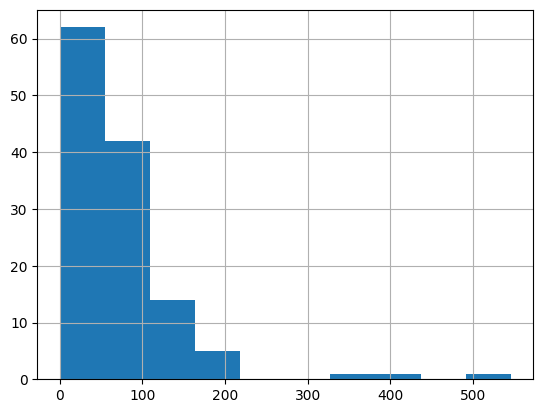

In [4]:
#Number of sentences in the dataset
len_col = [len(prop) for prop in senators["initiative_list"]]
pd.Series(len_col).hist()

<AxesSubplot:>

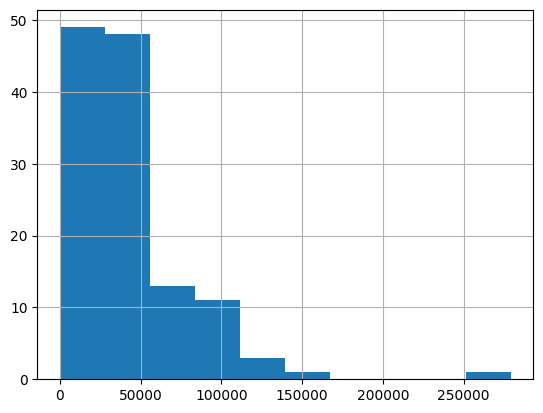

In [5]:
#Number of words in the dataset
len_col = [len(str(prop)) for prop in senators['initiatives_summary_dummy']]
               
pd.Series(len_col).hist()

In [6]:
#Exploring 'initiative_list'  
ex_i = len(senators['initiative_list'][1])
ex_i

39

In [7]:
##Exploring 'initiatives_summary_dummy' 
ex_s = senators['initiatives_summary_dummy'][1]
len(ex_s)

14197

## Model

In [8]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [9]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/bert2bert_shared-spanish-finetuned-summarization")
model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/bert2bert_shared-spanish-finetuned-summarization")

The following encoder weights were not tied to the decoder ['bert/pooler']
Some weights of EncoderDecoderModel were not initialized from the model checkpoint at mrm8488/bert2bert_shared-spanish-finetuned-summarization and are newly initialized: ['decoder.bert.encoder.layer.4.attention.output.dense.weight', 'decoder.bert.encoder.layer.10.attention.self.value.bias', 'decoder.bert.encoder.layer.10.attention.self.query.weight', 'decoder.bert.encoder.layer.3.attention.output.dense.bias', 'decoder.bert.encoder.layer.2.attention.self.key.weight', 'decoder.bert.encoder.layer.5.attention.self.key.weight', 'decoder.bert.encoder.layer.0.attention.output.dense.bias', 'decoder.bert.encoder.layer.4.attention.output.LayerNorm.bias', 'decoder.bert.encoder.layer.0.attention.self.query.weight', 'decoder.bert.encoder.layer.9.output.LayerNorm.weight', 'decoder.bert.encoder.layer.0.output.LayerNorm.bias', 'decoder.bert.encoder.layer.3.output.LayerNorm.weight', 'decoder.bert.encoder.layer.10.output.dense.we

The following encoder weights were not tied to the decoder ['bert/pooler']


### Option 1 -- 'initiatives_summary_dummy'

In [ ]:
inputs = tokenizer.encode("RESUMEN: " + ex_s, return_tensors="pt", max_length=511, truncation=True)
len(inputs[0])

In [ ]:
resumen = model.generate(
    inputs, 
    max_length=10000,
    min_length=40, 
    length_penalty=2.0, 
    num_beams=4, 
    early_stopping=True)

In [ ]:
print(tokenizer.decode(resumen[0]))

In [ ]:
prop_inc_t = senators['initiatives_summary_dummy_split']
prop_inc_t[0]

In [ ]:
#Split the concatenated initiatives for each senator into bites smaller than 511 to be able to consider inside the model.
senators["initiatives_summary_dummy_split"] = ""

n = 511

for i, row in senators.iterrows():
    if not row["initiative_list"] == []:
        initiatives_split = [row["initiatives_summary_dummy"][i:i+n] for i in range(0, len(row["initiatives_summary_dummy"]), n)]
        senators.at[i, "initiatives_summary_dummy_split"] = initiatives_split
    else:
        senators.at[i, "initiatives_summary_dummy_split"] = []

In [ ]:
senators.head(2)

In [ ]:
len(senators['initiatives_summary_dummy_split'][0]

In [ ]:
senators['initiatives_summary_dummy_split'][0]

In [ ]:
def summarizeRow(prop_inc_t, resumentList, inputsList):
    for parag in prop_inc_t:
        inputs = tokenizer.encode(parag, return_tensors="pt", max_length=511, truncation=True)
        inputsList.append(inputs)
        resumen = model.generate(
            inputs, 
            max_length=200,
            min_length=5, 
            length_penalty=2.0, 
            num_beams=4, 
            early_stopping=True)
        resumentList.append(tokenizer.decode(resumen[0]))

resumentList = []
inputsList = []

summarizeRow(prop_inc_t[0], resumentList, inputsList)

In [ ]:
for row in prop_inc_t[:5]:
    resumentList = []
    inputsList = []

    summarizeRow(row, resumentList, inputsList)
    
    print(inputsList)
    print(resumentList)

### Option 2 -- 'initiative_list'

In [10]:
#Example
senators['initiative_list'][35]

['Propone expedir un nuevo ordenamiento que reglamente el proceso de revocación de mandato contemplado en la fracción IX del artículo 35 Constitucional. Determina que iniciar el proceso de revocación de mandato es un derecho y una obligación: la solicitud procederá siempre que 3% de la ciudadanía inscrita en la lista nominal, distribuidas en al menos 17 Entidades Federativas a su vez representen el 3% en cada una de ellas. La solicitud sólo podrá presentarse por una sola ocasión durante los 3 meses posteriores a la conclusión del tercer año de ejercicio constitucional del Presidente de la Republica. La pregunta que deberá incluir la convocatoria emitida por la autoridad electoral, una vez que haya verificado el cumplimiento de los requisitos para que sea procedente, será: ¿Está de acuerdo con que se revoque el mandato de [Nombre de la persona titular de la Presidencia de la República] para que sea removido del cargo?\r\nY las respuestas posibles solo serán: SI o NO. Regula las atribuci

In [11]:
#Function that performs the summary by row
def summarizeRow(prop_inc_t, resumentList, inputsList):
    for parag in prop_inc_t:
        inputs = tokenizer.encode(parag, return_tensors="pt", max_length=511, truncation=True)
        inputsList.append(inputs)
        resumen = model.generate(
            inputs, 
            max_length=250,
            min_length=5, 
            length_penalty=2.0, 
            num_beams=6, 
            early_stopping=True)
        resumentList.append(tokenizer.decode(resumen[0]))

In [12]:
resumentList_2 = []
inputsList_2 = []

summarizeRow(senators['initiative_list'][0], resumentList_2, inputsList_2)

2023-07-15 08:17:24.408104: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-15 08:17:25.193124: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-15 08:17:25.193184: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-15 08:17:25.252543: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-15 08:17:28.401226: W tensorflow/stream_executor/platform/de

In [13]:
#Adding BETO to dataset
senators['BETO_summary'] = ""
senators.head(2)

,senator_id,Apellidos,Nombre,Fraccion,Legislatura,Estado,Sexo,tipoEleccion,Suplente,estadoOrigen,...,telefono,extension,estatus,direccion,id,senadores,attendance_score,initiative_list,initiatives_summary_dummy,BETO_summary
0,1160,Botello Montes,José Alfredo,PAN,64,Querétaro,Hombre,Senador Electo por el Principio de Mayoría Rel...,NaN,Querétaro,...,5345 3000,4183 y 4184,en_funciones,"Av Paseo de la Reforma No. 135, Hemiciclo Piso...",1,José Alfredo Botello Montes,0.958904,[Pretende garantizar a los miembros del Servic...,Pretende garantizar a los miembros del Servici...,
1,1162,Rojas Loreto,Estrella,PAN,64,Querétaro,Mujer,Senadora Electa por el Principio de Mayoría Re...,NaN,Querétaro,...,5345 3000,3323,en_funciones,"Av Paseo de la Reforma No. 135, Hemiciclo Piso...",2,Estrella Rojas Loreto,0.973913,[Propone que el Estado apoye la investigación ...,Propone que el Estado apoye la investigación e...,


In [ ]:
#For the entire dataset ... (only a few in the following example) ... change this value
#index = 0
#for row in senators['initiative_list'][:2]:
    #resumentList_2 = []
    #inputsList_2 = []

    #summarizeRow(row, resumentList_2, inputsList_2)
    #senators['BETO_summary'][index] = resumentList_2
    #index += 1
    #print(inputsList_2)
    #print (index)
    #print(resumentList_2)

#senators.head(2)

In [14]:
#For the entire dataset ... (only a few in the following example) ... change this value
index = 0
for row in senators['initiative_list']:
    resumentList_2 = []
    inputsList_2 = []

    summarizeRow(row, resumentList_2, inputsList_2)
    senators['BETO_summary'][index] = resumentList_2
    index += 1
    #print(inputsList_2)
    print (index)
    #print(resumentList_2)

senators.head(2)

/tmp/ipykernel_6130/3635060889.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  senators['BETO_summary'][index] = resumentList_2


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70


KeyboardInterrupt: 

In [ ]:
(senators["BETO_summary"][35])

In [ ]:
senators.to_csv(r'/Users/mimihuerta/code/jomilu93/sivico/data/senators_data_updated.csv')

https://albertauyeung.github.io/2020/06/19/bert-tokenization.html/

### Option 3 -- deprecated

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
model = AutoModelForMaskedLM.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")

In [ ]:
inputs_2 = tokenizer.encode("RESUMEN: " + a, return_tensors="pt", max_length=1000, truncation=True)
inputs_2

In [ ]:
resumen_2 = model.generate(
    inputs, 
    max_length=500, 
    min_length=40, 
    length_penalty=2.0, 
    num_beams=4, 
    early_stopping=True)

In [ ]:
print(tokenizer.decode(resumen_2[0]))

### Notes

In [ ]:
tokenizer.model_max_lenght
model.config.max_position_embeddings()
embeddings = TransformerWordEmbeddings(
    "path/to/model",
    layers="-1",
    subtoken_pooling="first",
    fine_tune=True,
    use_context=True,
    allow_long_sentences=True,
    model_max_length=512  # pass length